# Module 2 Project - Do discounts work?

Using Microsoft's Northwind dummy database, the aim of this project is extract data to answer some key business questions. The three questions are: 

1. [Do discounts have a statistically significant effect on the number of products customers order?](#products) If so, at what level(s) of discount?
2. [Are discounts effective for all employees?](#employees)
3. [As the manager in the British Isles, are there any regions that are signficantly different to mine measured by quantity per order?](#manager)

The structure of each answer is:
1. Set up the null and alternative hypothesis
2. Extract the data using the sqlite3 python library and create a pandas dataframe
3. Split the data into control and experiment
4. Perform a statistical test and draw conclusions

Below is the ERD for the Northwind Database

<img src="files/Northwind_ERD.png">

<a id='products'></a>

# Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

H0: Discounts do not have an effect on the number of products customers order  
H1: Discounts do have an effect on the number of products customers order

We will use a p value of 0.05 and this is a two-tailed test

In this analysis we:
1. Check for normality
2. Visualise the difference in means
3. Find the effect size to see whether there is any practical use to our conclusion
4. See whether different discount levels are more or less effective using ANOVA and Tukey's HSD test for difference in means

## Extracting the data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stat
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison



conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [2]:
#Check actual table names, as they are slightly different from the ERD
cur.execute("""
SELECT name FROM sqlite_master where type='table';
""")
print(cur.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


In [3]:
#We are interesting in Quantity and Discount, both of which are in the OrderDetail table
cur.execute("""
SELECT * FROM OrderDetail;
""")
table = cur.fetchall()

In [4]:
# Create the dataframe
cols = [i[0] for i in cur.description]
df = pd.DataFrame.from_records(data = table, columns=cols)
cur.close()
conn.close()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2155 non-null   object 
 1   OrderId    2155 non-null   int64  
 2   ProductId  2155 non-null   int64  
 3   UnitPrice  2155 non-null   float64
 4   Quantity   2155 non-null   int64  
 5   Discount   2155 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [6]:
# Check what the different discounts being applied are. 
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [7]:
#Create another binary column that indicates discount or no discount
df['Discount_binary'] = np.where(df['Discount']>0,1,0)

#Split up the data into two groups - discount and non-discount
experiment = df['Quantity'][df['Discount_binary']==1]
control = df['Quantity'][df['Discount_binary']==0]

In [8]:
#Get summary of each group
exp_mean = experiment.mean();
control_mean = control.mean();
exp_var = experiment.var();
control_var = control.var();

print("""      Discount mean: {}
         Discount variance: {}
         Non-discount mean: {}
         Non_discount varian: {}
      """.format(exp_mean,exp_var,control_mean,control_var))

      Discount mean: 27.10978520286396
         Discount variance: 431.4526878869016
         Non-discount mean: 21.715261958997722
         Non_discount varian: 306.512327685884
      


The summary above shows us that the mean quantity ordered for discounted products is indeed higher. We also note the variances are not equal, which has an impact on the t test later.

Next we perform a visual test to check for normality and see that both distributions are likely from a normal distribution.

(NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119),
 NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57))

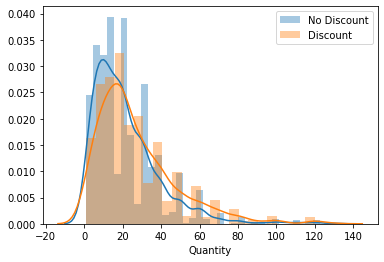

In [10]:
sns.distplot(control, label = "No Discount")
sns.distplot(experiment, label = "Discount")
plt.legend()

stat.normaltest(control), stat.normaltest(experiment)

Lets create sampling distributions of the means for each distribution, to see what the overlap looks like. The plot below seems to show that there is a signficant difference between the means. We will conduct a t test to confirm. 

In [11]:
control_means = []
experiment_means = []

for i in range(500):
    sample_control = control.sample(300)
    sample_experiment = experiment.sample(300)
    control_means.append(sample_control.mean())
    experiment_means.append(sample_experiment.mean())

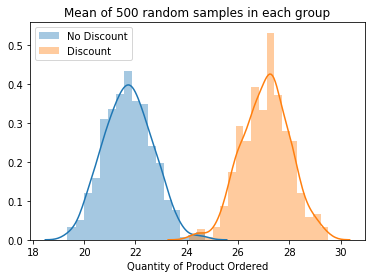

In [13]:
sns.distplot(control_means, label = "No Discount")
sns.distplot(experiment_means, label = "Discount")
plt.legend();
plt.xlabel("Quantity of Product Ordered");
plt.title('Mean of 500 random samples in each group');

In [14]:
#given variances are not equal, we will not use the Student t-test, but instead use Welch's t-test. Note we are using
# the original samples in the t test, not the distribution of means shown above. That is there as a visual test, and to
#demonstrate the Central Limit Theorem.
stat.ttest_ind(experiment,control,equal_var=False)

Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)

In [16]:
#What is the effect size?
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx)*np.std(x, ddof=1) ** 2 + (ny)*np.std(y, ddof=1) ** 2) / dof)

cohen_d(experiment,control)

0.2861395762937942

In [17]:
#Use ANOVA to see if there is a statistically significant difference between discount levels

formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

#So there is a statistically significant difference between discount levels. Now we need to find out which ones. 

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


In [18]:
#Given the very low numbers of small discounts, we will remove these now 
df_update = df.drop(df[(df.Discount <= 0.06) & (df.Discount > 0.0)].index)

df_update.Discount.value_counts()

0.00    1317
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [19]:
mc = MultiComparison(df_update['Quantity'], df_update['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    0.1   3.5217 0.1272 -0.5562  7.5996  False
   0.0   0.15   6.6669  0.001  2.4093 10.9245   True
   0.0    0.2   5.3096 0.0053  1.0995  9.5197   True
   0.0   0.25    6.525  0.001  2.2305 10.8195   True
   0.1   0.15   3.1452 0.5287 -2.4132  8.7035  False
   0.1    0.2   1.7879    0.9 -3.7342  7.3099  False
   0.1   0.25   3.0033 0.5725 -2.5834  8.5899  False
  0.15    0.2  -1.3573    0.9 -7.0133  4.2987  False
  0.15   0.25  -0.1419    0.9  -5.861  5.5772  False
   0.2   0.25   1.2154    0.9 -4.4684  6.8993  False
----------------------------------------------------
[0.   0.1  0.15 0.2  0.25]


## Conclusion

1. Our Welch t test for unequal variances tells us that we should reject the null hypothesis at p = 0.05 and say that that there is a statistically significant difference in order quantity for discounted products. 

2. Our ANOVA test tells us that there is a statistically significant difference between discount levels

3. Our Tukey HSD shows that the 15%, 20% and 25% discounts are all better than no discount. However the differences between discount levels of 15%, 20% and 25% need to be investigated further as there is no significant difference between each of the means. So we cannot say that a product at 20% discount will sell more than a product at 15% discount.

Recommendation: Continue to use discounts where the business objective is to increase order quantity. Use only the 15% discount as there is no evidence higher discounts increase sales. 

<a id='employees'></a>

# Question 2: Are discounts effective for all employees?

This analysis requires multiple t tests as there are 9 employees. We are at risk of False Positives (rejecting the null hypothesis when it is true). So we need to use the Bonferroni correction, effectively reducing the p value of 0.05 by a factor of 9.

In [20]:
#apply the Bonferroni correction when conducting multiple t-tests at the same time

In [21]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

cur.execute("""
SELECT od.Quantity, od.Discount, o.EmployeeId FROM OrderDetail od
LEFT JOIN "Order" o ON (o.Id = od.OrderId)
LEFT JOIN Customer c ON (c.Id = o.CustomerId)
;
""")
table = cur.fetchall()
cur.close()
conn.close()

In [22]:
cols = [i[0] for i in cur.description]
print(cols)
df2 = pd.DataFrame.from_records(data = table, columns=cols)

['Quantity', 'Discount', 'EmployeeId']


In [23]:
df2.head()

,Quantity,Discount,EmployeeId
0,12,0.0,5
1,10,0.0,5
2,5,0.0,5
3,9,0.0,6
4,40,0.0,6


In [24]:
#p value based on a total 0.05 value
p = 0.05 / 9
p

0.005555555555555556

In [25]:
#check variances for each control and experiment group for each employee
results = []
for i in range(1,10):
    control = df2['Quantity'][(df2.EmployeeId == i) & (df2.Discount == 0.0)]
    experiment = df2['Quantity'][(df2.EmployeeId == i) & (df2.Discount != 0.0)]
    
    result = control.var(), experiment.var(), stat.normaltest(control), stat.normaltest(experiment)
    
    results.append([i,result])
results

#So we must use ttest with unequal variances again (Welch's t test)
#We must remove employee 9 from the test as data not normally distributed

[[1,
  (303.2023012075638,
   498.5901603095634,
   NormaltestResult(statistic=83.64758219553543, pvalue=6.857381539696132e-19),
   NormaltestResult(statistic=52.31304660034787, pvalue=4.368841258699928e-12))],
 [2,
  (302.7637102734662,
   662.1817543859653,
   NormaltestResult(statistic=84.50077667081159, pvalue=4.4759939172606625e-19),
   NormaltestResult(statistic=27.975348210743363, pvalue=8.41841480917549e-07))],
 [3,
  (344.9362945895201,
   323.66532860343546,
   NormaltestResult(statistic=76.94409958900292, pvalue=1.957947609102798e-17),
   NormaltestResult(statistic=30.320934840465092, pvalue=2.6055094719441575e-07))],
 [4,
  (253.73230522088403,
   408.231813435433,
   NormaltestResult(statistic=125.85613258003713, pvalue=4.684767620975767e-28),
   NormaltestResult(statistic=46.574635124820276, pvalue=7.699215653769103e-11))],
 [5,
  (446.45644283121595,
   417.42080654587943,
   NormaltestResult(statistic=51.116446884497805, pvalue=7.947025229552631e-12),
   NormaltestResul

In [26]:
results = []

for i in range(1,9):
    control = df2['Quantity'][(df2.EmployeeId == i) & (df2.Discount == 0.0)]
    experiment = df2['Quantity'][(df2.EmployeeId == i) & (df2.Discount != 0.0)]
    
    result = stat.ttest_ind(experiment,control,equal_var=False)
    
    results.append([i,result])

results

[[1,
  Ttest_indResult(statistic=2.5564292088533116, pvalue=0.011202460047369944)],
 [2,
  Ttest_indResult(statistic=3.8613956046915865, pvalue=0.00019270687008469972)],
 [3,
  Ttest_indResult(statistic=1.1745103338121519, pvalue=0.24152666387933233)],
 [4,
  Ttest_indResult(statistic=3.8717478589466245, pvalue=0.00013221896108609902)],
 [5,
  Ttest_indResult(statistic=0.8542141305592196, pvalue=0.39476686722159315)],
 [6, Ttest_indResult(statistic=0.6119186155708318, pvalue=0.5417420117098031)],
 [7,
  Ttest_indResult(statistic=2.3524253501240273, pvalue=0.019819499043053263)],
 [8, Ttest_indResult(statistic=-0.17002051867211823, pvalue=0.86516529621725)]]

## Conclusion

1. Based on a p value of 0.006 employees 2 and 4 sell higher quantities due to discounts, and others don't. 
2. We need further data for employee 9 before we can draw any conclusions

Recommendation: It is difficult to provide one without knowing the working practices, but there might be some selling tactics that employees 2 and 4 use that could be shared more widely.

<a id='manager'></a>

# Question 3: As the manager in the British Isles, are there any regions that are signficantly different to mine measured by quantity per order?

In [27]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

cur.execute("""
SELECT od.Quantity, od.Discount, c.Region FROM OrderDetail od
LEFT JOIN "Order" o ON (o.Id = od.OrderId)
LEFT JOIN Customer c ON (c.Id = o.CustomerId)
;
""")
table = cur.fetchall()
cur.close()
conn.close()

In [28]:
cols = [i[0] for i in cur.description]
df3 = pd.DataFrame.from_records(data = table, columns=cols)

In [29]:
df3.Region.value_counts()

Western Europe     736
North America      427
South America      304
British Isles      190
Northern Europe    143
Southern Europe    137
Scandinavia         70
Central America     55
Eastern Europe      16
Name: Region, dtype: int64

In [30]:
#Given it's more than two categories, we can use ANOVA

In [31]:
formula = 'Quantity ~ C(Region)'
lm = ols(formula, df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df          F        PR(>F)
C(Region)   40817.353539     8.0  14.641888  5.449622e-21
Residual   720971.784575  2069.0        NaN           NaN


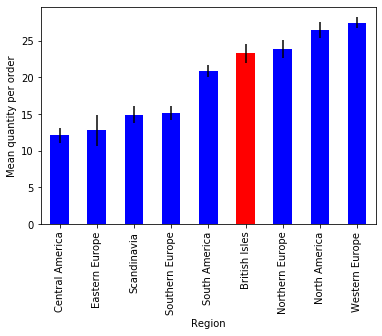

In [32]:
#So region does make a difference
#Which regions make a difference
#print standard error of the mean for the error bars
error = df3.groupby(['Region'],sort = True)['Quantity'].sem().sort_values()
Quant_by_region = df3.groupby(['Region'],sort = True)['Quantity'].mean().sort_values().plot.bar(yerr = error,color = ["blue","blue","blue","blue","blue","red","blue","blue","blue"]);
plt.ylabel("Mean quantity per order");

In [41]:
df3.Region = pd.Categorical(df3.Region)

In [42]:
mc1 = MultiComparison(df3['Quantity'], list(df3['Region']))
result = mc1.tukeyhsd()
 
print(result)
print(mc.groupsunique)

#Eastern Europe is not considered statistically smaller. Going back to the variance and error bars, 
#the reason in the variation in the data. We know it's the smallest sample size, which therefore makes sense. 
#Need more data here. 

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------
  British Isles Central America -11.1856 0.0034 -20.1797 -2.1916   True
  British Isles  Eastern Europe -10.4822  0.479 -25.7729  4.8085  False
  British Isles   North America   3.2018 0.5976  -1.9208  8.3243  False
  British Isles Northern Europe   0.5165    0.9  -5.9865  7.0194  False
  British Isles     Scandinavia  -8.3519 0.0425 -16.5647 -0.1391   True
  British Isles   South America   -2.377    0.9  -7.8092  3.0553  False
  British Isles Southern Europe  -8.1633 0.0035  -14.747 -1.5797   True
  British Isles  Western Europe   4.1794 0.1476  -0.6005  8.9594  False
  British Isles             nan  -2.4895    0.9 -10.4249  5.4458  False
Central America  Eastern Europe   0.7034    0.9 -15.9813 17.3881  False
Central America   North America  14.3874  0.001   5.9723 22.8025

## Conclusion

1. The ANOVA test shows us there is a statisically significant difference between regions
2. Our visual plot shows there are 5 regions that have a lower mean quantity per order. However only three of these, Central America, Scandinavia and Southern Europe are significantly below. Eastern Europe does not have enough data, and therefore has a higher standard error and so is not considered significantly different according to Tukey's HSD. 
3. No region has a significantly higher mean quantity per order

Recommendation: Dig down into whether discounts can help those regions with lower order quantities. Also we could look at customer demographics. 